# Modelo 4
| Specification | Metric |
|---------------|--------|
|Model          |DeepLabV3+        |
|Encoder        |ResNext101_32x8d        |
|Batch Size     |4        |
|Epochs         |20        |
|Loss Function  |JaccardLoss        |
|Weights  |Imagenet        |
|Learning rate  |0.01        |

# Import libraries

Installing the necessary additional libraries

In [100]:
import os, glob, random, shutil, csv, re
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

%matplotlib inline

# Loading the dataset

## Image classification function definition
Here we define a function that gets all the unique colors in an image to then match those colors to their corresponding class.

In [101]:
def get_img_classes(img_path):
    """
    Given an image path, gets its unique colors and matches them to their
    respective classes from the class_dict.csv file
    """

    # Create the classes dictionary from the class_dict file
    classes_dict = {'urban_land': np.array([0, 255, 255]),
                    'agriculture_land': np.array([255, 255, 0]),
                    'rangeland': np.array([255, 0, 255]),
                    'forest_land': np.array([0, 255, 0]),
                    'water': np.array([0, 0, 255]),
                    'barren_land': np.array([255, 255, 255]),
                    'unknown': np.array([0, 0, 0])
                    }

    # Load the image from the given path
    img = cv2.imread(img_path)

    # Convert to rgb
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image to speed up the class matching process
    img_rgb = cv2.resize(img_rgb, (128, 128), interpolation= cv2.INTER_LINEAR)

    # Get the unique rgb values in the image
    unique_colors = np.unique(img_rgb.reshape(-1, img_rgb.shape[2]), axis=0)

    matching_classes = []

    # Match the unique colors to their respective classes
    for color in unique_colors:
        for class_name, class_rgb in classes_dict.items():
            if np.array_equal(color, class_rgb):
                matching_classes.append(class_name)
                break  # No need to check other classes once a match is found

    return matching_classes

## Making the CSV
Here we iterate through every image in our dataset to build our metadata csv file. We get the image's id, split (train, test or valid), its satelite image path, the mask's path and its corresponding classes.

In [102]:
def create_csv(images_path):

    # get the list of files in the directory
    files = os.listdir(images_path)

    # create a dictionary to store the data, and onvert it to a dataframe at the end
    data = {"img_id": [], "split": [], "sat_img_path": [], "mask_path": [], "classes": []}
    for file in files:
        # get the path
        path = os.path.join(images_path, file)
        # get the id
        id = path.split('\\')[-1].split('_')[-2]
        # get the split
        split = path.split('/')[-1].split('\\')[-2]
        # if the id is already in the dictionary, check if split is satelite or mask, and add the path to the corresponding column
        if id in data["img_id"]:
            if "_sat" in file:
                data["sat_img_path"][data["img_id"].index(id)] = path
            else:
                data["mask_path"][data["img_id"].index(id)] = path
                data["classes"][data["img_id"].index(id)] = get_img_classes(path)
        # if the id is not in the dictionary, add it to the dictionary
        else:
            data["img_id"].append(id)
            data["split"].append(split)
            data["sat_img_path"].append(path if "_sat" in file else None)
            data["mask_path"].append(path if "_mask" in file else None)
            data["classes"].append(get_img_classes(path) if "_mask" in file else None)

    # convert the dictionary to a dataframe
    df = pd.DataFrame(data)
    # save the dataframe to a csv file
    df.to_csv("trainmetadata.csv", index=False)

    return df

In [103]:
train_data_path = "DSet/train"
test_data_path = "DSet/test"

df_image_paths = create_csv(train_data_path)

## Loading images to the Pytorch dataloader


## Data preparation

Data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

1. Read the images.
2. Resize the images.
3. Convert to tensors and normalize the data.
4. Pack them in batches.

We'll achieve these steps using torchvision.transforms, and the Imagefolder utilities.

First, we extract the classes into a dictionary in order to access the contents later.

### Creating the dataloader with the Dataset class

In [104]:
rgb_to_numberedClass = {0: np.array([0, 255, 255]),
1: np.array([255, 255, 0]),
2: np.array([255, 0, 255]),
3: np.array([0, 255, 0]),
4: np.array([0, 0, 255]),
5: np.array([255, 255, 255]),
6: np.array([0, 0, 0])
}

def rgb_to_index(mask, classes_dict):
    """
    Converts a mask with RGB values to a mask with class indices.
    """
    class_index_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    for class_index, (class_name, rgb_value) in enumerate(classes_dict.items()):
        class_index_mask[(mask == rgb_value).all(axis=-1)] = class_index
    return class_index_mask

In [105]:
class CropsDataset(Dataset):
    def __init__(self, annotations_file, classes, transform=None):
        self.labels_df = pd.read_csv(annotations_file)
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx, 2] # Sat_img index is 2 in the csv
        mask_path = self.labels_df.iloc[idx, 3] # Mask index is 3 in the csv

        image = Image.open(img_path)
        mask = Image.open(mask_path)
        label = self.labels_df.iloc[idx, 4] # The classes(label) index is 4 in the csv

        # Resize our images before classifying each pixel
        resize = transforms.Resize(size=(512, 512))
        image = resize(image)
        mask = resize(mask)

        # Convert the mask to a ground truth image based on the rgb_to_numberedClass dictionary
        ground_truth_np = rgb_to_index(np.array(mask), rgb_to_numberedClass)
        # Transform to a tensor of 7 dimensions [0, 5, 3, 2, 5] -> [1, 0, 0, 0, 0] [0, 0, 0, 0, 0] [0, 0, 0, 1, 0] [0, 0, 1, 0, 0] [0, 1, 0, 0 ,1] [0, 0, 0, 0, 0] [0, 0, 0, 0, 0]
        # tensor = torch.from_numpy(ground_truth_np)

        # num_classes = 7
        # ground_truth = torch.zeros((num_classes,) + tensor.shape)

        # # Iterate over each class
        # for i in range(num_classes):
        #     # Find indices where the value equals the class
        #     indices = (tensor == i).nonzero()
        #     # Set corresponding elements to 1 in the desired tensor
        #     ground_truth[i, indices[:, 0], indices[:, 1]] = 1

        # ground_truth = 1 - ground_truth

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            ground_truth_np = self.transform(ground_truth_np)

        return image, mask, label, ground_truth_np
        #return image, mask, label, ground_truth, ground_truth_np

### Setup for splitting into a training and validation dataset

In [106]:
split_percentage = 0.8

train_image_count = int(len(df_image_paths.index) * split_percentage)
validation_image_count = len(df_image_paths.index) - train_image_count

print(f'Training images: {train_image_count} Validation images: {validation_image_count}')

Training images: 642 Validation images: 161


### Defining the transform

In [107]:
# Example transform
image_transforms = transforms.Compose([
    #transforms.Resize(size=(256, 256)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

### Passing the dataset into the Pytorch dataloader

In [108]:
labels_file = "trainmetadata.csv"
crop_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
numbered_classes = [i for i in range(len(crop_classes))]

# Transforming the dataset into the CropsDataset class
train_dataset = CropsDataset(annotations_file=labels_file, classes=numbered_classes, transform=image_transforms)
# Splitting the dataset into a training and validation dataset
train_dataset, val_dataset = random_split(train_dataset, lengths=[train_image_count, validation_image_count])

# Loads the classes into the pytorch Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, pin_memory=True)

print(f'Training dataset: {len(train_dataset)}')
print(f'Validation dataset: {len(val_dataset)}')

print(f'Classes: {train_dataset.dataset.classes}')
print(f'Transform: {train_dataset.dataset.transform}')

Training dataset: 642
Validation dataset: 161
Classes: [0, 1, 2, 3, 4, 5, 6]
Transform: Compose(
    ToTensor()
)


# Visualizing the batch

These dictionaries will help us go from the numbered classes to the named classes and vice versa

In [109]:
idx_to_class = {i:j for i, j in enumerate(crop_classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print(idx_to_class)
print(class_to_idx)

{0: 'urban_land', 1: 'agriculture_land', 2: 'rangeland', 3: 'forest_land', 4: 'water', 5: 'barren_land', 6: 'unknown'}
{'urban_land': 0, 'agriculture_land': 1, 'rangeland': 2, 'forest_land': 3, 'water': 4, 'barren_land': 5, 'unknown': 6}


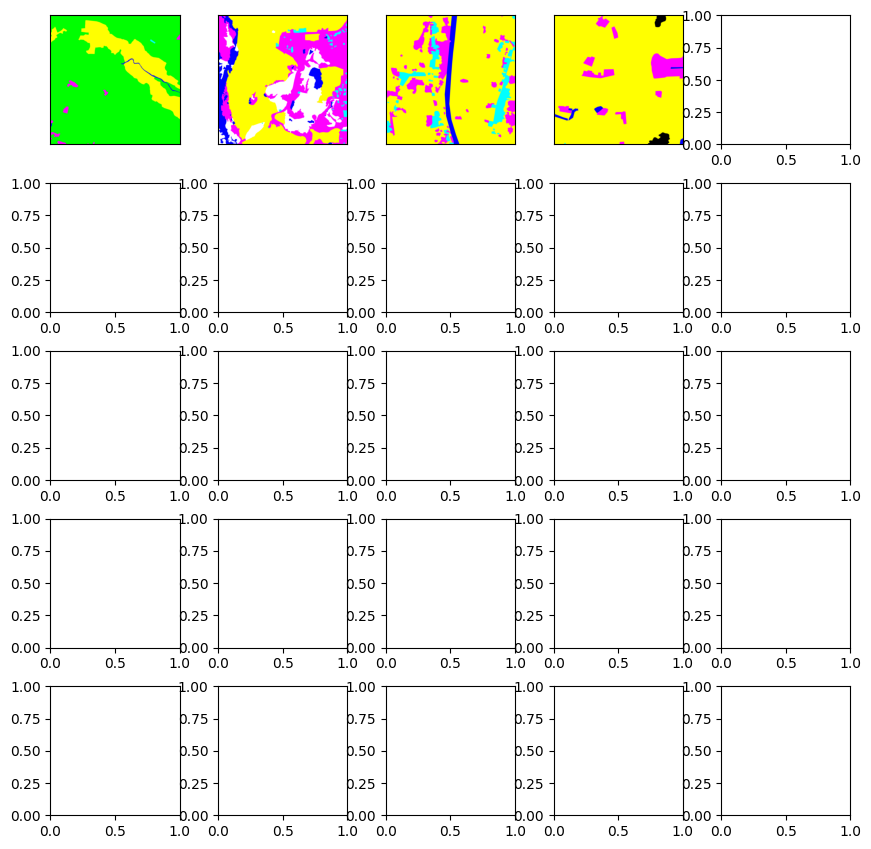

In [110]:
# # Create a 5x5 subplot figure
f, ax = plt.subplots(5, 5, figsize=(10, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=0.)
train_batch = next(iter(train_dataloader))

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

# Iterate over the first 25 test images
for idx in range(4):
    # Calculate the row and column index for the subplot
    row = idx // 5
    col = idx % 5

    mask = train_batch[1][idx].numpy()

    # image = np.reshape(image, (150, 150, 3))
    mask = mask.transpose((1, 2, 0))
    mask = (mask * 255.0).astype("uint8")

    label = train_batch[2][idx]
    #print(label)

    ax[row, col].imshow(mask)
    #ax[row, col].set_title(label)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

# Implementing the model

In [111]:
class CropModel(L.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes):
        '''
            Initializes an instance of the SemanticSegmentation class.

            Parameters:
            - arch (str): The architecture of the model.
            - encoder_name (str): The name of the encoder.
            - in_channels (int): The number of input channels.
            - out_classes (int): The number of output classes.
        '''
        super().__init__()

        '''
            It is important to note that we are not using a trained encoder. To use a trained encoder, change
            The value in the encoder_weight parameter.
        '''
        self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, encoder_weights='imagenet')
        self.num_classes = out_classes

        '''
           These are used to store the computed true positive, false positive, false negative and true negative 'pixels' for each image and class
        '''
        self.tp = None
        self.fp = None
        self.fn = None
        self.tn = None

        '''
            These are used to store the computed losses for each stage
        '''
        self.losses = {
            'valid': [],
            'train': [],
            'test': []
        }

        '''
            These parameters are used to normalize the input image. Models from the segmentation_models_pytorch library
            require the input image to be normalized. The mean and standard deviation values are used to normalize the image.
            The mean and standard deviation values are obtained from the get_preprocessing_params function of the encoders module.
        '''
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        '''
            Jaccard Loss: similar to Dice loss. It is also known as Intersection over Union (IoU) loss, as it quantifies the similarity between predicted and target segmentation masks by measuring the intersection ratio to their union. Jaccard loss is widely used in tasks where accurate boundary delineation is critical, such as medical image segmentation and object detection.
        '''
        self.loss_fn = smp.losses.JaccardLoss(mode='multiclass', from_logits=True)

    def forward(self, image):

        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch[0]

        '''
            Shape of the image should be (batch_size, num_channels, height, width)
            if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        '''
        assert image.ndim == 4

        '''
            Check that image dimensions are divisible by 32,
            encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
            downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
            following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
            and we will get an error trying to concat these features
        '''
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[3]

        # Shape of the mask should be [batch_size, num_classes, height, width] for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 7, NOT 0 and 255 for multiclass segmentation
        assert mask.max() <= 7.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # print(f"\n{mask.size()}")
        # print(type(mask))
        # print(logits_mask.size())
        # print(type(logits_mask))

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask.long())

        # Lets compute metrics for some threshold: first convert mask values to probabilities, then apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        pred_mask_norm = torch.argmax(pred_mask, dim=1, keepdim=True)

        '''
            We will compute IoU metric by two ways
              1. dataset-wise
              2. image-wise
            but for now we just compute true positive, false positive, false negative and
            true negative 'pixels' for each image and class
            these values will be aggregated in the end of an epoch
        '''
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask_norm.long(), mask.long(), mode="multiclass", num_classes=self.num_classes)

        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

        self.losses[stage].append(loss)

        return loss

    def shared_epoch_end(self, stage):
        # aggregate step metics
        tp = self.tp
        fp = self.fp
        fn = self.fn
        tn = self.tn

        '''
            Per image IoU means that we first calculate IoU score for each image
            and then compute mean over these scores
        '''
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        '''
            Dataset IoU means that we aggregate intersection and union over whole dataset
            and then compute IoU score. The difference between dataset_iou and per_image_iou scores
            in this particular case will not be much, however for dataset
            with "empty" images (images without target class) a large gap could be observed.
            Empty images influence a lot on per_image_iou and much less on dataset_iou.
        '''
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_loss": torch.stack(self.losses[stage]).mean(),
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True, logger=True)

    '''
        These are pytorch lightning hooks that are called during the training, validation and testing steps.
        Hooks are used to perform additional operations during these steps. In this case, we are using the hooks
        to compute the loss and metrics for each step and epoch.
    '''
    def training_step(self, batch):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

Available architecture options: Available options are: ['unet', 'unetplusplus', 'manet', 'linknet', 'fpn', 'pspnet', 'deeplabv3', 'deeplabv3plus', 'pan']"

In [112]:
model = CropModel("deeplabv3plus", "resnext101_32x8d", in_channels=3, out_classes=7)

## Training the model

In [113]:
# Early stop is a callback that is used to stop the training process when the validation loss does not improve. In this case, we are
# using the EarlyStopping callback to stop the training process when the validation loss does not improve for 3 epochs.
earlystop_callback = EarlyStopping('valid_loss', patience=3)

trainer = L.Trainer(max_epochs=20, logger=CSVLogger(save_dir="logs/", name="crop_seg-model"), callbacks=[earlystop_callback], log_every_n_steps=50)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type          | Params
------------------------------------------
0 | model   | DeepLabV3Plus | 89.9 M
1 | loss_fn | JaccardLoss   | 0     
------------------------------------------
89.9 M    Trainable params
0         Non-trainable params
89.9 M    Total params
359.654   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\munij\miniconda3\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\munij\miniconda3\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


c:\Users\munij\miniconda3\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0:   1%|          | 1/161 [00:02<05:28,  0.49it/s, v_num=18]

c:\Users\munij\miniconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 19: 100%|██████████| 161/161 [03:52<00:00,  0.69it/s, v_num=18, valid_loss=0.457, valid_per_image_iou=0.662, valid_dataset_iou=0.662, train_loss=0.507, train_per_image_iou=0.225, train_dataset_iou=0.225]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 161/161 [03:57<00:00,  0.68it/s, v_num=18, valid_loss=0.457, valid_per_image_iou=0.662, valid_dataset_iou=0.662, train_loss=0.507, train_per_image_iou=0.225, train_dataset_iou=0.225]


In [114]:
# We verify the training using the validate method of the trainer object. The validate method returns the metrics for the validation dataset.
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 41/41 [00:40<00:00,  1.00it/s]
[{'valid_loss': 0.4555334448814392, 'valid_per_image_iou': 0.6621321439743042, 'valid_dataset_iou': 0.6621321439743042}]


,step,train_dataset_iou,train_loss,train_per_image_iou,valid_dataset_iou,valid_loss,valid_per_image_iou
epoch,,,,,,,
0,160.0,0.216437,0.608960,0.216437,0.216437,0.570979,0.216437
1,321.0,0.300372,0.585935,0.300372,0.300372,0.522435,0.300372
2,482.0,0.412030,0.570146,0.412030,0.412030,0.521107,0.412030
3,643.0,0.350043,0.560741,0.350043,0.350043,0.505631,0.350043
4,804.0,0.525561,0.550812,0.525561,0.525561,0.496229,0.525561
5,965.0,0.610098,0.547730,0.610098,0.610098,0.491639,0.610098
6,1126.0,0.550240,0.543254,0.550240,0.550240,0.489154,0.550240
7,1287.0,0.534064,0.537046,0.534064,0.534064,0.483797,0.534064
8,1448.0,0.310841,0.532830,0.310841,0.310841,0.479183,0.310841


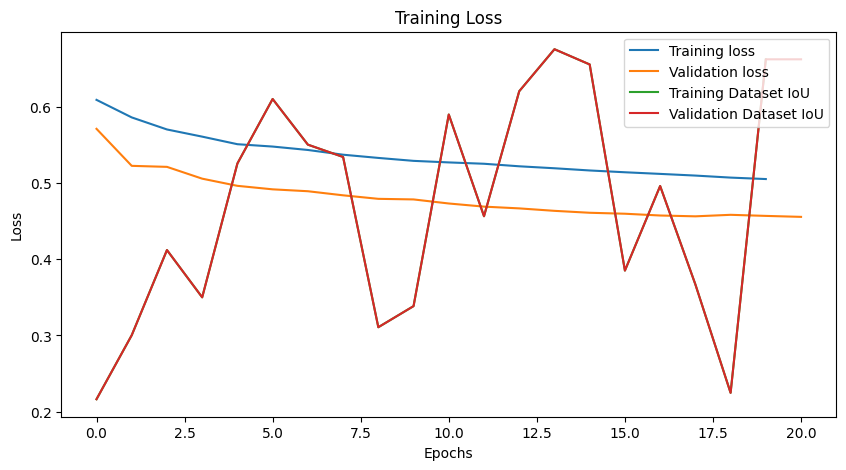

In [115]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

display(df_epochs)

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
ax.plot(df_epochs['train_loss'], label="Training loss")
ax.plot(df_epochs['valid_loss'], label="Validation loss")

ax.plot(df_epochs['train_dataset_iou'], label="Training Dataset IoU")
ax.plot(df_epochs['valid_dataset_iou'], label="Validation Dataset IoU")

# Plot the training loss over epochs
# Plot the validation loss over epochs
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

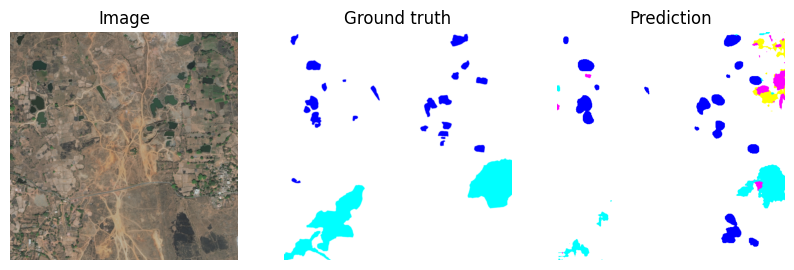

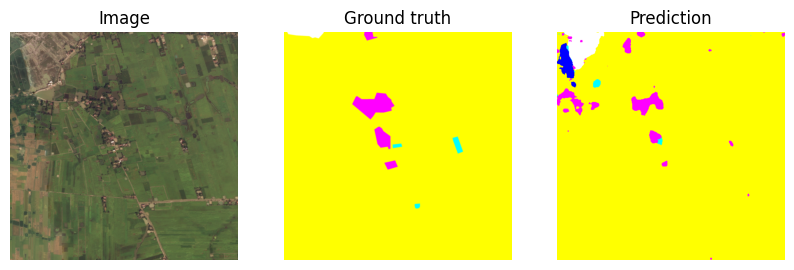

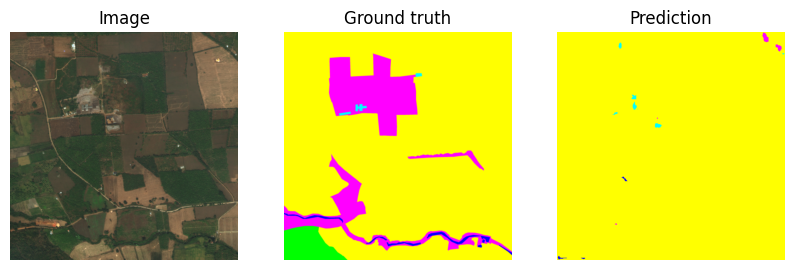

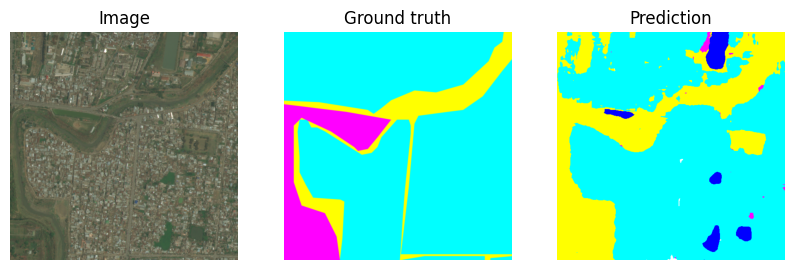

In [116]:
batch = next(iter(val_dataloader)) # TODO: MAKE A TEST DATALOADER
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = logits.sigmoid()

rgb_to_numberedClass = {0: np.array([0, 255, 255]),
                        1: np.array([255, 255, 0]),
                        2: np.array([255, 0, 255]),
                        3: np.array([0, 255, 0]),
                        4: np.array([0, 0, 255]),
                        5: np.array([255, 255, 255]),
                        6: np.array([0, 0, 0])
}

# Transform the prediction masks with the rgb_to_numberedClass dictionary according to the highest probability mathching the layer to the color
pr_masks = torch.argmax(pr_masks, dim=1)
pr_masks = pr_masks.cpu().numpy()

# Convert pr_masks to RGB according to the rgb_to_numberedClass dictionary
pr_masks = np.array([[[rgb_to_numberedClass[i] for i in row] for row in pr_mask] for pr_mask in pr_masks])



for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().transpose(1, 2, 0))
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask)
    plt.title("Prediction")
    plt.axis("off")

    plt.show()